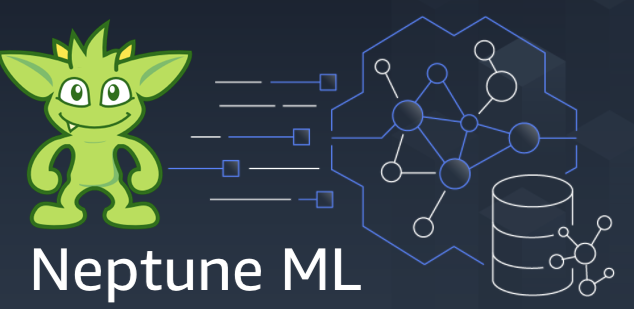

# Link Prediction - Introduction
In this Notebook we are going to examine the process of using Amazon Neptune ML feature to perform link prediction in a property graph.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This notebook take approximately 1 hour to complete</div>

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models within Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy to use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph. 

For this notebook we are going to show how to perform a common machine learning task known as **link prediction**.  Link prediction is a unsupervised machine learning task where a model built using nodes and edges in the graph to predict whether an edge exists between two particular nodes.  Link prediction is not unique to GNN based models (look at DeepWalk or node2vec) but the GNN based models in Neptune ML provide additional context to the predictions by combining the connectivity and features of the local neighborhood of a node to create a more predictive model.

Link prediction is commonly used to solve many common buisness problems such as:

* Predicting group membership in a social or identity network
* [Entity Resolution in an identity graph](https://github.com/awslabs/sagemaker-graph-entity-resolution/blob/master/source/sagemaker/dgl-entity-resolution.ipynb)
* Knowledge graph completion
* Product recommendation

Neptune ML uses a four step process to automate the process of creating production ready GNN models:

1. **Load Data** - Data is loaded into a Neptune cluster using any of the normal methods such as the Gremlin drivers or using the Neptune Bulk Loader.
2. **Export Data** - A service call is made specifying the machine learning model type and model configuration parameters.  The data and model configuration parameters are then exported from a Neptune cluster to an S3 bucket.
3. **Model Training** - A set of service calls are made to pre-process the exported data, train the machine learning model, and then generate an Amazon SageMaker endpoint that exposes the model.
4. **Run Queries** - The final step is to use this inference endpoint within our Gremlin queries to infer data using the machine learning model.

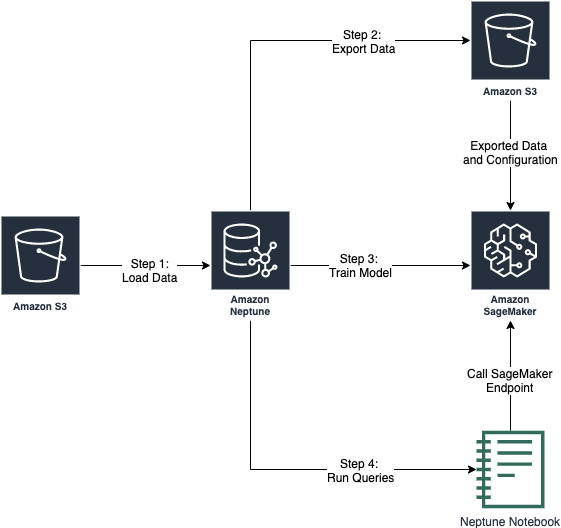

For this notebook we'll use the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) provided by [GroupLens Research](https://grouplens.org/datasets/movielens/). This dataset consists of movies, users, and ratings of those movies by users. 

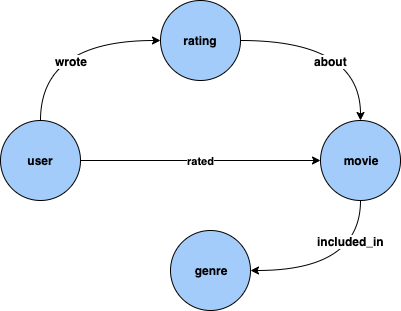

For this notebook we'll walk through how Neptune ML can predict product recommendations in a product knowledge graph.  To demonstrate this we'll predict the movies a user would be most likely to rate as well as which users are most likely to rate a given movie.  We'll walk through each step of loading and exporting the data, configuring and training the model, and finally we'll show how to use that model to infer the genre of movies using Gremlin traversals. 

## Checking that we are ready to run Neptune ML 
Run the code below to check that this cluster is configured to run Neptune ML.

In [ ]:
import neptune_ml_utils as neptune_ml
neptune_ml.check_ml_enabled()

If the check above did not say that this cluster is ready to run Neptune ML jobs then please check that the cluster meets all the pre-requisites defined [here](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview).

# Load the data
The first step in building a Neptune ML model is to load data into the Neptune cluster. Loading data for Neptune ML follows the standard process of ingesting data into Amazon Neptune, for this example we'll be using the Bulk Loader. 

We have written a script that automates the process of downloading the data from the MovieLens websites and formatting it to load into Neptune. All you need to provide is an S3 bucket URI that is located in the same region as the cluster.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This is the only step that requires any specific input from the user, all remaining cells will automatically propogate the required values.</div>

In [ ]:
s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

Now that you have provided an S3 bucket, run the cell below which will download and format the MovieLens data into a format compatible with Neptune's bulk loader.

In [ ]:
response = neptune_ml.prepare_movielens_data(s3_bucket_uri)

This process only takes a few minutes and once it has completed you can load the data using the `%load` command in the cell below.

In [ ]:
%load -s {response} -f csv -p OVERSUBSCRIBE --run

## Check to make sure the data is loaded

Once the cell has completed, the data has been loaded into the cluster. We verify the data loaded correctly by running the traversals below to see the count of nodes by label:  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The numbers below assume no other data is in the cluster</div>

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold()

If our nodes loaded correctly then the output is:

* 19 genres
* 1682 movies
* 100000 rating
* 943 users

To check that our edges loaded correctly we check the edge counts:

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold()

If our edges loaded correctly then the output is:

* 100000 about
* 2893 included_in
* 100000 rated
* 100000 wrote


## Preparing for export

With our data validated let's remove a few `rated` vertices so that we can build a model that predicts these missing connections.  In a normal scenario, the data you would like to predict is most likely missing from the data being loaded so removing these values prior to building our machine learning model simulates that situation.

Specifically, let's remove the `rated` edgesfor `user_1`, to provide us with a few candidate vertices to run our link prediction tasks.  Let's start by taking a look at what `rated` edges currently exist.

In [ ]:
%%gremlin

g.V('user_1').outE('rated')

Now let's remove these edges to simulate them missing from our data.

In [ ]:
%%gremlin
g.V('user_1').outE('rated').drop()

Checking our data again we see that the edges have now been removed.

In [ ]:
%%gremlin
g.V('user_1').outE('rated')

# Export the data and model configuration

**Note:** Before exporting data ensure that Neptune Export has been configured as described here: [Neptune Export Service](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html#machine-learning-data-export-service-run-export)

With our product knowledge graph loaded we are ready to export the data and configuration which will be used to train the ML model.  

The export process is triggered by calling to the [Neptune Export service endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html).  This call contains a configuration object which specifies the type of machine learning model to build, in this example node classification, as well as any feature configurations required.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The configuration used in this notebook specifies only a minimal set of configuration options meaning that our model's predictions are not as accurate as they could be.  The parameters included in this configuration are one of a couple of sets of options available to the end user to tune the model and optimize the accuracy of the resulting predictions.</div>

The configuration options provided to the export service are broken into two main sections, selecting the target and configuring features. 

## Selecting the target

In the first section, selecting the target, we specify what type of machine learning task will be run. To run a link prediction mdoel do not specify any `targets` in the `additionalParams` value.  Unlike node classification or node regression, link prediction can be used to predict any edge type that exists in the graph between any two vertices.  Becasue of this, there is no need to define a target set of values.


## Configuring features
The second section of the configuration, configuring features, is where we specify details about the types of data stored in our graph and how the machine learning model should interpret that data.  In machine learning, each property is known as a feature and these features are used by the model to make predictions.  

In machine learning, each property is known as a feature and these features are used by the model to make predictions.  When data is exported from Neptune all properties of all vertices are included.  Each property is treated as a separate feature for the ML model.  Neptune ML does its best to infer the correct type of feature for a property, in many cases, the accuracy of the model can be improved by specifying information about the property used for a feature.  By default Neptune ML puts features into one of two categories:

* If the feature represents a numerical property (float, double, int) then it is treated as a `numerical` feature type. In this feature type data is represented as a continuous set of numbers.  In our example, the `age` of a `user` would best be represented as a numerical feature as the age of a user is best represented as a continuous set of values.
* All other property types are represented as `category` features.  In this feature type, each unique value of data is represented as a unique value in the set of classifications used by the model.  In our MovieLens example the `occupation` of a `user` would represent a good example of a `category` feature as we want to group users that all have the same job.

If all of the properties fit into these two feature types then no configuration changes are needed at the time of export.  However, in many scenarios these defaults are not always the best choice.  In these cases, additional configuration options should be specified to better define how the property should be represented as a feature. 

One common feature that needs additional configuration is numerical data, and specifically properties of numerical data that represent chunks or groups of items instead of a continuous stream.

Let's say that instead of wanting `age` to be represented as a set of continuous values we want to represent it as a set of discrete buckets of values (e.g. 18-25, 26-24, 35-44, etc.).  In this scenario we want to specify some additional attributes of that feature to bucket this attribute into certain known sets.  We achieve this by specifying this feature as a `numerical_bucket`.  This feature type takes a range of expected values, as well as a number of buckets, and groups data into buckets during the training process.

Another common feature that needs additional attributes are text features such as names, titles, or descriptions.  While Neptune ML will treat these as categorical features by default the reality of these features is that they will likely be unique for each node.  For example, since  the `title` property of a `movie` node does not fit into a category grouping our model would be better served by representing this type of feature as a `text_word2vec` feature.  A `text_word2vec` feature uses techniques from natural language processing to create a vector of data that represents a string of text.  

In our export example below we have specified that the `title` property of our `movie` should be exported and trained as a `text_word2vec` feature and that our `age` field should range from 0-100 and that data should be bucketed into 10 distinct groups. 

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Important</b>: The example below is an example of a minimal amount of the features of the model configuration parameters and will not create the most accurate model possible.  Additional options are available for tuning this configuration to produce an optimal model are described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-parameters.html">Neptune Export Process Parameters</a></div>

Running the cell below we set the export configuration and run the export process.  Neptune export is capable of automatically creating a clone of the cluster by setting `cloneCluster=True` which takes about 20 minutes to complete and will incur additional costs while the cloned cluster is running.  Exporting from the existing cluster takes about 5 minutes but requires that the `neptune_query_timeout` parameter in the [parameter group](https://docs.aws.amazon.com/neptune/latest/userguide/parameters.html) is set to a large enough value (>72000) to prevent timeout errors.

In [ ]:
export_params={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
            "cloneCluster": False
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export',
"additionalParams": {
        "neptune_ml": {
          "version": "v2.0",
         "features": [
            {
                "node": "movie",
                "property": "title",
                "type": "word2vec"
            },
            {
                "node": "user",
                "property": "age",
                "type": "bucket_numerical",
                "range" : [1, 100],
                "num_buckets": 10
            }
         ]
        }
      },
"jobSize": "medium"}

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

# ML data processing, model training, and endpoint creation

Once the export job is completed we are now ready to train our machine learning model and create the inference endpoint. Training our Neptune ML model requires three steps.  
  
<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The cells below only configure a minimal set of parameters required to run a model training.</div>

## Data processing
The first step (data processing) processes the exported graph dataset using standard feature preprocessing techniques to prepare it for use by DGL. This step performs functions such as feature normalization for numeric data and encoding text features using word2vec. At the conclusion of this step the dataset is formatted for model training. 

This step is implemented using a SageMaker Processing Job and data artifacts are stored in a pre-specified S3 location once the job is complete.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Data Processing](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing.html)
* [dataprocessing command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-dataprocessing.html)

Run the cells below to create the data processing configuration and to begin the processing job.

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto generated
training_job_name=neptune_ml.get_training_job_name('link-prediction')

processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}

## Model training
The second step (model training) trains the ML model that will be used for predictions. The model training is done in two stages. The first stage uses a SageMaker Processing job to generate a model training strategy. A model training strategy is a configuration set that specifies what type of model and model hyperparameter ranges will be used for the model training. Once the first stage is complete, the SageMaker Processing job launches a SageMaker Hyperparameter tuning job. The SageMaker Hyperparameter tuning job runs a pre-specified number of model training job trials on the processed data, and stores the model artifacts generated by the training in the output S3 location. Once all the training jobs are complete, the Hyperparameter tuning job also notes the training job that produced the best performing model.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Model Training](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-model-training.html)
* [modeltraining command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-modeltraining.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: Link prediction is a more computationally complex model than classification or regression so training this model will take 2-3 hours</div>

In [ ]:
training_params=f"""
--job-id {training_job_name} 
--data-processing-id {training_job_name} 
--instance-type ml.p3.2xlarge
--s3-output-uri {str(s3_bucket_uri)}/training
--max-hpo-number 2
--max-hpo-parallel 2 """

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params}

## Endpoint creation
The final step is to create the inference endpoint which is an Amazon SageMaker endpoint instance that is launched with the model artifacts produced by the best training job. This endpoint will be used by our graph queries to  return the model predictions for the inputs in the request. The endpoint once created stays active until it is manually deleted. Each model is tied to a single endpoint.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Inference Endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-inference-endpoint.html)
* [Endpoint command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-endpoints.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The endpoint creation process takes ~5-10 minutes</div>

In [ ]:
endpoint_params=f"""
--id {training_job_name}
--model-training-job-id {training_job_name}"""

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

Once this has completed we get the endpoint name for our newly created inference endpoint.  The cell below will set the endpoint name which will be used in the Gremlin queries below.   

In [ ]:
endpoint=endpoint_results['endpoint']['name']

# Querying using Gremlin

Now that we have our inference endpoint setup let's query our product knowledge graph to show how to predict how likely it is that a user will rate a movie.  The need to predict the likelyhood of connections in a product knowledge graph is commonly used to provide recommendations for products that a customer might purchase.

Unlike node classification and node regression, link prediction can infer any of the edge labels that existed in our graph when the model was created.  In our model this means we could infer the probability that a `wrote`, `about`, `rated`, or `included_in` edge exists between any two vertices.  However for this example we are going to focus on inferring the `rated` edges between the `user` and `movie` vertices. 

## Predicting what movies a user will rate

Before we predict what movies `user_1` is most likely to rate let's verify that our graph does not contain any `rated` edges for `user_1`.


In [ ]:
%%gremlin
g.V('user_1').out('rated').hasLabel('movie').valueMap()

As expected, their are not any `rated` edges for `user_1`.  Maybe `user_1` is a new user in our system and we want to provide them some product recommendations.  Let's modify the query to predict what movies `user_1` is most likely to rate. 

First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The endpoint values are automatically passed into the queries below</div>

Second, when we ask for the link within our query we use the `out()` step to predict the target node or the `in()` step to predict the source node.  For each of these steps we need to specify the type of model being used with a with() step (`with("Neptune#ml.prediction")`).

Putting these items together we get the query below, which returns the movies that` user_1` is likely to rate.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
    V('user_1').out('rated').with("Neptune#ml.prediction").hasLabel('movie').valueMap('title')

Great, we can now see that we are predicted edges showing that `Sleepers` is the movie that `user_1` is most likely to rate.  In the example above we predicted the target node but we can also use the same mechanism to predict the source node.  

Let's turn that question around and say that we had a product and we wanted to find the people most likely to rate this product.

## Predicting the top 10 users most likely to rate a movie
To accomplish this we would want to start at the movie vertex and predict the rated edge back to the user.  Since we want to return the top 10 recommended users we need to use the `.with("Neptune#ml.limit",10)` configuration option.  Combining these together we get the query below which finds the top 10 users most likely to rate `Apollo 13`.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
    with("Neptune#ml.limit",10).
      V().has('title', 'Apollo 13 (1995)').
        in('rated').with("Neptune#ml.prediction").hasLabel('user').id()

With that we have sucessfully been able to show how you can use link prediction to predict edges starting at either end.

From the examples we have shown here you can begin to see how the ability to infer unknown connections within a graph starts to enable many interesting and unique use cases within Amazon Neptune.  

# Cleaning Up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.

In [ ]:
neptune_ml.delete_endpoint(training_job_name)

In addition to the inference endpoint the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see Deleting a Stack on the [Deleting a Stack on the Amazon Web Services CloudFormation Console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html). Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.